In [41]:
import keras
from keras.applications import VGG16
import matplotlib.pyplot as plt
import numpy as np
# from keras.models import Model
from keras.preprocessing import image

In [42]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [43]:
PATH_OF_DATA= '/content/gdrive/"My Drive"/train_70'
!ls {PATH_OF_DATA}

Closed_Eyes  Open_Eyes


In [44]:
batchsize=8

In [45]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/content/gdrive/My Drive/train_70/'
validation_data_dir = '/content/gdrive/My Drive/val_20/'

train_datagen= ImageDataGenerator(rescale=1./255, rotation_range=0.2,shear_range=0.2,
    zoom_range=0.2,width_shift_range=0.2,
    height_shift_range=0.2)

val_datagen= ImageDataGenerator(rescale=1./255, rotation_range=0.2,shear_range=0.2,
    zoom_range=0.2,width_shift_range=0.2,
    height_shift_range=0.2)

In [46]:
train_data = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(80, 80),
        batch_size=8,
        class_mode='categorical')

validation_data = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(80, 80),
        batch_size=8,
        class_mode='categorical')

Found 2800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [47]:
test_data_dir = '/content/gdrive/My Drive/test_10/'
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(test_data_dir,
        target_size=(80, 80),
        batch_size=8,
        class_mode='categorical')

Found 400 images belonging to 2 classes.


In [48]:
vgg = VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (80, 80, 3))

# Here we freeze the last 4 layers
# Layers are set to trainable as True by default
for layer in vgg.layers:
    layer.trainable = False

# Let's print our layers
for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

def Fc(bottom_model, num_classes):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model


58889256/58889256 [==============================] - 0s 0us/step
0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [49]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
# from keras.layers.normalization import BatchNormalization
from keras.models import Model

In [50]:
num_classes = 2

FC_Head = Fc(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = FC_Head)

print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 80, 80, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 80, 80, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 40, 40, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 40, 40, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 40, 40, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 20, 20, 128)       0     

In [51]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_path = '/content/gdrive/My Drive/Model/Model_3_5/vgg_70_20_10.h5'
checkpoint = ModelCheckpoint(model_path,
                            monitor='val_loss',save_best_only=True,verbose=3)
earlystop = EarlyStopping(monitor = 'val_loss', patience=7, verbose= 3, restore_best_weights=True)

learning_rate = ReduceLROnPlateau(monitor= 'val_loss', patience=3, verbose= 3, )

callbacks=[checkpoint,earlystop,learning_rate]

In [73]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit_generator(train_data,steps_per_epoch=train_data.samples//batchsize,
                   validation_data=validation_data,
                   validation_steps=validation_data.samples//batchsize,
                   callbacks=callbacks,
                    epochs=5)

Epoch 1/5


<ipython-input-73-fc97a5cf3cc7>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data,steps_per_epoch=train_data.samples//batchsize,


350/350 [==============================] - ETA: 0s - loss: 0.0853 - accuracy: 0.9704
Epoch 1: val_loss did not improve from 0.10474
350/350 [==============================] - 313s 891ms/step - loss: 0.0853 - accuracy: 0.9704 - val_loss: 0.2311 - val_accuracy: 0.9025 - lr: 0.0010
Epoch 2/5
350/350 [==============================] - ETA: 0s - loss: 0.0829 - accuracy: 0.9746
Epoch 2: val_loss did not improve from 0.10474
350/350 [==============================] - 308s 880ms/step - loss: 0.0829 - accuracy: 0.9746 - val_loss: 0.1866 - val_accuracy: 0.9025 - lr: 0.0010
Epoch 3/5
350/350 [==============================] - ETA: 0s - loss: 0.0713 - accuracy: 0.9775
Epoch 3: val_loss did not improve from 0.10474
350/350 [==============================] - 311s 889ms/step - loss: 0.0713 - accuracy: 0.9775 - val_loss: 0.4487 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 4/5
350/350 [==============================] - ETA: 0s - loss: 0.0650 - accuracy: 0.9782
Epoch 4: val_loss did not improve from 0.1047

In [75]:
loss_tr, acc_tr = model.evaluate_generator(train_data)

print(loss_tr)
print(acc_tr)

<ipython-input-75-c527480a9875>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss_tr, acc_tr = model.evaluate_generator(train_data)


0.08422785252332687
0.9649999737739563


In [76]:
loss_vr, acc_vr = model.evaluate_generator(validation_data)

print(loss_vr)
print(acc_vr)

<ipython-input-76-cc7cefa02e4d>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss_vr, acc_vr = model.evaluate_generator(validation_data)


0.11700792610645294
0.9537500143051147


In [77]:
loss_test, acc_test = model.evaluate_generator(test_data)
print(loss_test)
print(acc_test)

<ipython-input-77-3f370467cf05>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss_test, acc_test = model.evaluate_generator(test_data)


0.10349570214748383
0.9574999809265137


In [69]:
# # Plot train and validation loss
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Train and Validation Loss')
# plt.legend()

# # Plot train and validation accuracy
# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Train and Validation Accuracy')
# plt.legend()

# plt.show()

In [70]:
# # Evaluate on test data
# loss_test, acc_test = model.evaluate_generator(test_data)
# print("Test Loss:", loss_test)
# print("Test Accuracy:", acc_test)

# # Plot test loss and accuracy
# plt.figure(figsize=(8, 4))
# plt.subplot(1, 2, 1)
# # plt.bar(['Test Loss'], [loss_test], color='blue')
# plt.plot(['Test Loss'], [loss_test], color='blue')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Test Loss')

# plt.subplot(1, 2, 2)
# # plt.bar(['Test Accuracy'], [acc_test], color='green')
# plt.plot(['Test Accuracy'], [acc_test], color='green')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Test Accuracy')

# plt.show()

1/1 [==============================] - 0s 234ms/step


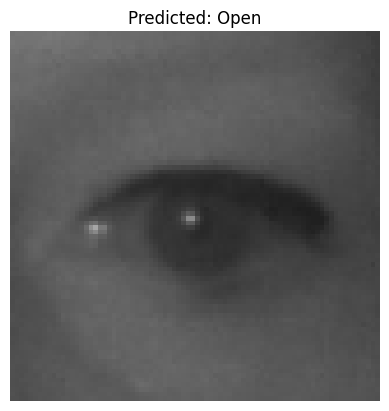

In [78]:
# Load the trained model
model_path = '/content/gdrive/My Drive/Model/Model_3_5/vgg_70_20_10.h5'
model = keras.models.load_model(model_path)

# Select a random image from the test dataset
random_test_image = np.random.choice(test_data.samples)

# Load and preprocess the image
img_path = test_data.filepaths[random_test_image]
img = image.load_img(img_path, target_size=(80, 80))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Rescale to [0, 1]

# Predict the class probabilities for the image
predictions = model.predict(img_array)

# Interpret the predictions
class_names = ['Closed', 'Open']
predicted_class = np.argmax(predictions)

# Visualize the result
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted: {class_names[predicted_class]}')
plt.show()

1/1 [==============================] - 0s 158ms/step


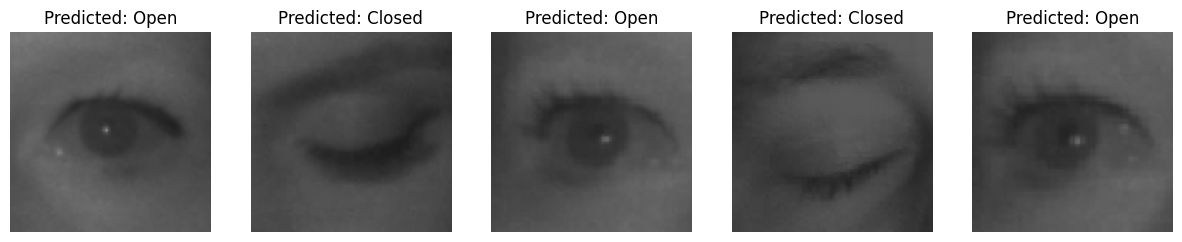

In [85]:
# Select 5 random indices from the test dataset
random_indices = np.random.choice(test_data.samples, size=5, replace=False)

# Load the trained model
model_path = '/content/gdrive/My Drive/Model/Model_3_5/vgg_70_20_10.h5'
model = keras.models.load_model(model_path)

# Display the 5 random images with appropriate labels
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    img_path = test_data.filepaths[idx]
    img = image.load_img(img_path, target_size=(80, 80))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.  # Rescale to [0, 1]

    # Predict the class probabilities for the image
    predictions = model.predict(img_array)

    # Interpret the predictions
    class_names = ['Closed', 'Open']
    predicted_class = np.argmax(predictions)

    # Display the image with appropriate label
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class]}")
    plt.axis('off')

plt.show()